## 📥 Carga de datos y preprocesamiento

In [1]:
import pandas as pd
from pathlib import Path

# Configurar ruta del dataset
DATA_DIR = Path.cwd().resolve().parents[1]
df = pd.read_parquet(DATA_DIR / "data/01_raw/movies_dataset_2025-05-07.parquet")

# Selección de variables relevantes
use_features = [
    "title", "original_language", "popularity", "vote_average", "vote_count",
    "is_popular", "runtime", "budget", "revenue", "genres", "spoken_languages"
]
df = df[use_features]

# Limpieza básica
df.drop_duplicates(subset=[
    "original_language", "popularity", "vote_average", "vote_count",
    "is_popular", "runtime", "budget", "revenue"
], inplace=True)

df["is_popular"] = df["is_popular"].astype("int8")
df["original_language"] = df["original_language"].astype("category")

## ⚙️ Preprocesamiento de variables

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

# Variables categóricas y numéricas
cat_cols = ["original_language"]
num_cols = ["popularity", "vote_average", "vote_count", "runtime", "budget", "revenue"]

# Pipeline por tipo
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean"))
])

# Column transformer
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

# Aplicar preprocesamiento
preprocessed = preprocessor.fit_transform(df)

## 🔄 Cálculo de similitudes

In [3]:
from sklearn.metrics.pairwise import cosine_similarity

# Similaridad coseno entre todas las películas
cosine_sim = cosine_similarity(preprocessed, preprocessed)

# Selección de índice de referencia para comparación
idx = 0  # Cambiar por otro índice si deseas

## 🔍 Interpretabilidad no supervisada: Permutación y Sensibilidad

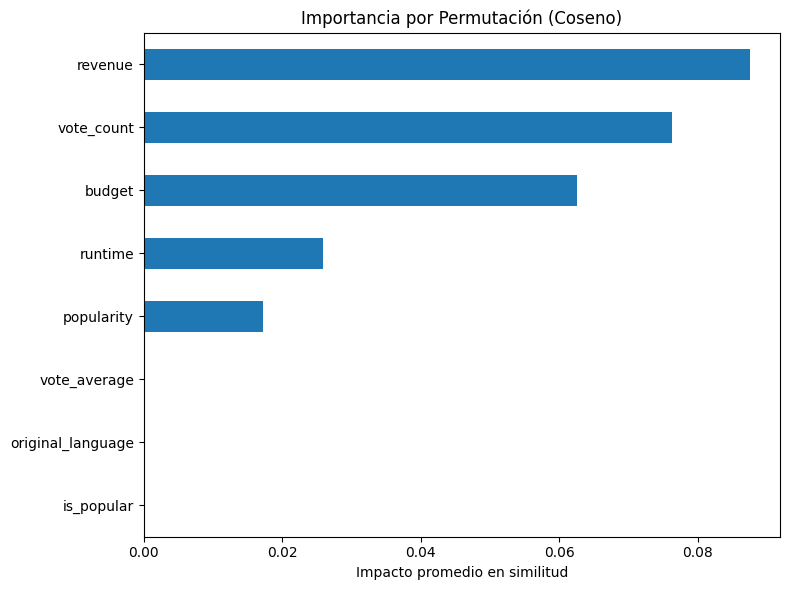

In [6]:
from sklearn.utils import shuffle
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def permutation_importance_unsupervised(
    df: pd.DataFrame, 
    preprocessor, 
    var: str, 
    idx: int = 0
) -> float:
    """
    Estimate global importance of a feature by shuffling it and comparing cosine similarity.
    """
    df_permuted = df.copy()
    df_permuted[var] = shuffle(df_permuted[var].values, random_state=42)
    
    X_permuted = preprocessor.transform(df_permuted)

    # slicing seguro para csr_matrix (mantiene 2D)
    sim_original = cosine_similarity(preprocessed[idx:idx+1], preprocessed).flatten()
    sim_permuted = cosine_similarity(preprocessed[idx:idx+1], X_permuted).flatten()

    return float(np.mean(np.abs(sim_original - sim_permuted)))

# Aplicar a columnas seleccionadas
cols_to_evaluate = [col for col in df.columns if col not in ["title", "genres", "spoken_languages"]]
perm_importance = {
    col: permutation_importance_unsupervised(df, preprocessor, col, idx=0)
    for col in cols_to_evaluate
}

# Visualizar
pd.Series(perm_importance).sort_values().plot.barh(figsize=(8, 6), title="Importancia por Permutación (Coseno)")
plt.xlabel("Impacto promedio en similitud")
plt.tight_layout()
plt.show()


In [8]:
# Sensibilidad local
def sensibilidad_variable(
    df: pd.DataFrame, 
    preprocessor, 
    var: str, 
    idx: int = 0, 
    delta: float = 1.0
) -> pd.DataFrame:
    """
    Estimate local sensitivity by modifying one variable and checking similarity change.
    """
    df_modified = df.copy()
    df_modified.loc[idx, var] += delta
    X_modified = preprocessor.transform(df_modified)

    # CORRECTO: slicing para mantener el tipo csr_matrix 2D
    sim_original = cosine_similarity(preprocessed[idx:idx+1], preprocessed).flatten()
    sim_modified = cosine_similarity(X_modified[idx:idx+1], X_modified).flatten()

    impacto = np.abs(sim_modified - sim_original)
    impacto_df = pd.DataFrame({
        "title": df["title"],
        "impacto_similitud": impacto
    })
    return impacto_df.sort_values("impacto_similitud", ascending=False).head(10)

# Ejemplo
sensibilidad_variable(df, preprocessor, var="vote_average", idx=0, delta=1.0)

,title,impacto_similitud
7046,Gaspard Proust : Dernier Spectacle,0.002536
5629,"Italia 1982, una storia azzurra",0.002479
4770,Solo Somos Carne,0.002374
553,RTI,0.002362
2521,Fly On,0.002353
1791,A Portrait of Jianghu: The Legend,0.002348
6815,Swinging,0.002337
1939,Ritmo de Natal,0.002310
221,Questi fantasmi,0.002309
1172,La Fulgurée,0.002309


## 🧾 Conclusiones de la Interpretabilidad

Se evaluó cómo influye cada variable en el sistema de recomendación basado en similitud de coseno. A continuación, los hallazgos clave:

📌 1. Variables más influyentes:

Las variables que más impactan la similitud entre películas son:

revenue, vote_count y budget → El sistema agrupa principalmente por éxito financiero y volumen de participación del público.

runtime y popularity → Tienen un impacto moderado.

vote_average, original_language e is_popular → Tienen poca influencia en la similitud calculada.

Esto sugiere que el sistema da más peso a lo cuantitativo que a lo cualitativo.

📌 2. Cambios puntuales:

Al modificar ligeramente una variable en una película específica (ej. vote_average), los cambios en el ranking de películas similares son leves. Las más afectadas suelen ser películas menos destacadas.


✅ Recomendaciones:

Si se quiere priorizar aspectos cualitativos o contextuales, como idioma o calificación promedio, conviene ajustar pesos o usar modelos supervisados.

Esta interpretación ayuda a alinear el sistema con los objetivos: ¿destacar lo más popular, lo más rentable o lo más relevante para cada usuario?